# Este modelo de red entrena un BiLSTM + CRF para la clasificación de NER sobre el corpus Conll2002. Este modelo tiene como entrada a la red la enterización del conjunto X de entrenamiento y la enterización y categorización  de los vectores de etiquetas. No usa embeddings.

In [1]:

import tensorflow as tf
#matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
!pip3 install sklearn-crfsuite
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


# Instalación del paquete nltk

In [3]:
import nltk
nltk.download('conll2002')
nltk.corpus.conll2002.fileids()

[nltk_data] Downloading package conll2002 to /home/deep/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [4]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))
eval_sents = list(nltk.corpus.conll2002.iob_sents('esp.testa'))
print(len(train_sents),len(max(train_sents,key=len)))
print(len(test_sents),len(max(test_sents,key=len)))
print(len(eval_sents),len(max(eval_sents,key=len)))

8323 1238
1517 202
1915 141
CPU times: user 1.18 s, sys: 41.8 ms, total: 1.23 s
Wall time: 1.22 s


In [5]:
print(train_sents[0])

[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]


# Hay que quitarle las sentencias de longitud 1238, 314 y 261

In [6]:
max_len_sent = []
for i, member in enumerate(train_sents):
    max_len_sent.append(len(member))
print(max_len_sent)
print ("Max value element : ", max(max_len_sent))

for i, member in enumerate(train_sents):
    if len(member) == 1238:
       m=train_sents.index(member) 
       #print(train_sents(k))
       for word in enumerate(member):
        print(word)
#print(member)
train_sents.pop(m)
print(len(train_sents),len(max(train_sents,key=len)))
for i, member in enumerate(train_sents):
    if len(member) == 314:
       p=train_sents.index(member) 
       #print(train_sents(k))
       
train_sents.pop(p)
print(len(train_sents),len(max(train_sents,key=len)))
#print(len(train_sents),len(max(train_sents,key=len)))
for i, member in enumerate(train_sents):
    if len(member) == 261:
       p=train_sents.index(member) 
       #print(train_sents(k))
       
train_sents.pop(p)
print(len(train_sents),len(max(train_sents,key=len)))

[11, 1, 40, 61, 50, 29, 38, 33, 8, 1, 38, 49, 59, 51, 49, 59, 43, 14, 1, 45, 22, 31, 32, 1, 8, 1, 26, 1, 2, 1, 67, 9, 1, 2, 1, 55, 4, 1, 2, 1, 43, 7, 1, 8, 1, 43, 9, 1, 37, 5, 1, 36, 11, 1, 14, 5, 1, 29, 8, 1, 15, 5, 1, 12, 8, 1, 16, 8, 1, 17, 5, 1, 18, 5, 1, 43, 1, 6, 1, 55, 1, 6, 1, 11, 11, 1, 53, 92, 10, 41, 21, 25, 32, 4, 58, 24, 35, 27, 12, 36, 34, 28, 11, 31, 13, 18, 9, 25, 14, 29, 17, 8, 1, 54, 34, 45, 48, 54, 8, 1, 57, 57, 24, 43, 32, 44, 60, 76, 51, 27, 8, 1, 57, 57, 24, 43, 32, 44, 60, 76, 51, 27, 5, 1, 4, 1, 59, 5, 1, 17, 5, 1, 2, 1, 24, 1, 5, 1, 33, 5, 1, 3, 1, 19, 2, 13, 1, 47, 43, 69, 44, 47, 43, 39, 36, 41, 42, 40, 37, 51, 55, 33, 60, 1, 41, 46, 57, 37, 44, 38, 52, 28, 34, 19, 37, 35, 14, 19, 46, 28, 37, 40, 26, 40, 26, 19, 26, 46, 34, 1, 49, 51, 48, 36, 53, 48, 25, 43, 74, 62, 32, 80, 62, 69, 8, 1, 32, 52, 53, 47, 8, 1, 50, 56, 47, 26, 61, 50, 28, 30, 23, 57, 22, 21, 55, 16, 51, 47, 28, 60, 64, 73, 61, 14, 50, 29, 21, 49, 36, 47, 52, 44, 9, 1, 49, 76, 53, 76, 47, 8, 1, 

# PARTE  1. PREPROCESAMIENTO DE LOS DATOS

In [7]:
def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [8]:
sent2tokens(train_sents[0])[0]
#sent2labels(train_sents[0])[0]

'Melbourne'

In [9]:
%%time
X_train = [sent2tokens(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2tokens(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

X_eval = [sent2tokens(s) for s in eval_sents]
y_eval = [sent2labels(s) for s in eval_sents]

CPU times: user 33.8 ms, sys: 3.45 ms, total: 37.3 ms
Wall time: 36.9 ms


In [10]:
print(X_train[2])
print(y_train[2])

['El', 'Abogado', 'General', 'del', 'Estado', ',', 'Daryl', 'Williams', ',', 'subrayó', 'hoy', 'la', 'necesidad', 'de', 'tomar', 'medidas', 'para', 'proteger', 'al', 'sistema', 'judicial', 'australiano', 'frente', 'a', 'una', 'página', 'de', 'internet', 'que', 'imposibilita', 'el', 'cumplimiento', 'de', 'los', 'principios', 'básicos', 'de', 'la', 'Ley', '.']
['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O']


In [11]:
import numpy as np

words, tagsss = set([]), set([])
 
for s in (X_train + X_eval + X_test):
    for w in s:
        words.add(w.lower())

for ts in (y_train + y_eval + y_test):
    for t in ts:
        tagsss.add(t)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0  # The special value used for padding
word2index['-OOV-'] = 1  # The special value used for OOVs
 
tag2index = {t: i + 2 for i, t in enumerate(list(tagsss))}
tag2index['-PAD-'] = 0  # The special value used to padding
tag2index['-OOV-'] = 1  # The special value used to padding

print (len(word2index))
print (len(tag2index))

np.save('../vectors/word2index.npy', word2index)
np.save('../vectors/tag2index.npy', tag2index)
print(tagsss)

27570
11
{'I-MISC', 'B-ORG', 'B-MISC', 'I-ORG', 'I-LOC', 'I-PER', 'B-LOC', 'O', 'B-PER'}


In [12]:
train_sentences_X, eval_sentences_X, test_sentences_X, train_tags_y, eval_tags_y, test_tags_y = [], [], [], [], [], []

for s in X_train:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    train_sentences_X.append(s_int)

for s in X_eval:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    eval_sentences_X.append(s_int)

for s in X_test:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
 
    test_sentences_X.append(s_int)

for s in y_train:
    s_int = []
    for w in s:
        try:
            s_int.append(tag2index[w])
        except KeyError:
            s_int.append(tag2index['-OOV-'])
            
    train_tags_y.append(s_int)

for s in y_eval:
    s_int = []
    for w in s:
        try:
            s_int.append(tag2index[w])
        except KeyError:
            s_int.append(tag2index['-OOV-'])
            
    eval_tags_y.append(s_int)

for s in y_test:
    s_int = []
    for w in s:
        try:
            s_int.append(tag2index[w])
        except KeyError:
            s_int.append(tag2index['-OOV-'])
            
    test_tags_y.append(s_int)


# Las matrices de los tags son de números indexados pequeños porque solo son 11 tags.  ({ORG, LOC, PER}  X IOB)

In [13]:
print("Longitudes de las Matrices:")
print(len(train_sentences_X))
print(len(eval_sentences_X))
print(len( test_sentences_X))
print(len(train_tags_y))
print(len(eval_tags_y))
print(len(test_tags_y))

print("\nMuestra de Datos presentes en las Matrices con las transformaciones:\n")


print(train_sentences_X[0])
print(eval_sentences_X[0])
print(test_sentences_X[0])
print(train_tags_y[0])
print(eval_tags_y[0])
print(test_tags_y[0])


Longitudes de las Matrices:
8320
1915
1517
8320
1915
1517

Muestra de Datos presentes en las Matrices con las transformaciones:

[8614, 1517, 17376, 3860, 6709, 26263, 10577, 1517, 11098, 3860, 8072]
[2890, 15962, 1517, 10708, 3860, 6709, 4338, 10577, 1517, 6361, 3860, 8072]
[26719, 21278, 6709, 4338, 10577, 1517, 6361, 3860, 8072]
[8, 9, 8, 9, 9, 9, 9, 9, 3, 9, 9]
[8, 6, 9, 8, 9, 9, 9, 9, 9, 3, 9, 9]
[8, 6, 9, 9, 9, 9, 3, 9, 9]


In [14]:
MAX_LENGTH1 = len(max(train_sentences_X, key=len))
MAX_LENGTH2 = len(max(eval_sentences_X, key=len))
MAX_LENGTH3 = len(max(test_sentences_X, key=len))

l = [MAX_LENGTH1, MAX_LENGTH2, MAX_LENGTH3]
MAX_LENGTH = max(l)

print(MAX_LENGTH)

202


# Se procede a Normalizar las matrices con la longitud de la columna=MAX_LENGTH1 para que todas contengan el mismo numero de columnas, con la longitud máxima de palabras encontradas anteriormente y se agregan ceros a la derecha en las posiciones que hacen falta en el vector. 

In [15]:
!pip3 install keras
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(train_sentences_X, maxlen=MAX_LENGTH, padding='post')
eval_sentences_X = pad_sequences(eval_sentences_X, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(test_sentences_X, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
eval_tags_y = pad_sequences(eval_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')
 
#print(train_sentences_X[0])
#print(train_sentences_X.shape)
#print(eval_sentences_X[0])
#print(eval_sentences_X.shape)
#print(test_sentences_X[0])
#print(test_sentences_X.shape)
#print(train_tags_y[0])
#print(train_tags_y.shape)
print(eval_tags_y[0])
print(eval_tags_y.shape)
#print(test_tags_y[0])
#print(test_tags_y.shape)

np.save('../vectors/train_sentences_X.npy', train_sentences_X)
np.save('../vectors/eval_sentences_X.npy', eval_sentences_X)
np.save('../vectors/test_sentences_X.npy', test_sentences_X)
np.save('../vectors/train_tags_y.npy', train_tags_y)
np.save('../vectors/eval_tags_y.npy', eval_tags_y)
np.save('../vectors/test_tags_y.npy', test_tags_y)

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Using TensorFlow backend.


[8 6 9 8 9 9 9 9 9 3 9 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(1915, 202)


In [16]:
def to_categoricals(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [17]:
import numpy as np
from keras.utils import to_categorical

def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

# Se realiza la categorización one-hot de las etiquetas o labels de entrenamiento, testeo y validación

In [18]:
cat_train_tags_y = to_categoricals(train_tags_y, len(tag2index))
cat_eval_tags_y  = to_categoricals(eval_tags_y, len(tag2index))
cat_test_tags_y  = to_categoricals(test_tags_y, len(tag2index))

print(cat_train_tags_y[1])
print(len(cat_train_tags_y))
print(len(cat_test_tags_y))

[[0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
8320
1517


# PARTE 2. ENTRENAMIENTO DEL MODELO DE RED.

# Estos comandos sirven para activar el modelo distribuido para el uso de las GPUs

In [40]:
!pip3 install git+https://www.github.com/keras-team/keras-contrib.git
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

input = Input(shape=(MAX_LENGTH,))
word_embedding_size = 150

# Embedding Layer
model = Embedding(input_dim=len(word2index), output_dim=word_embedding_size, input_length=MAX_LENGTH)(input)

# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = TimeDistributed(Dense(len(tag2index), activation="relu"))(model)  

# CRF Layer
crf = CRF(len(tag2index))

out = crf(model)  # output
model = Model(input, out)


#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])
model.summary()

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-uw0_r2am
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-uw0_r2am
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 202)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 202, 150)          4135500   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 202, 300)          361200    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 202, 11)           3311      


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [77]:
history  = model.fit(train_sentences_X, cat_train_tags_y,
                       validation_data=(eval_sentences_X, cat_eval_tags_y),
                       batch_size=32, 
                       epochs=50,
                       verbose=2)

Train on 8320 samples, validate on 1915 samples
Epoch 1/50
 - 41s - loss: -1.8524e-02 - crf_viterbi_accuracy: 0.9996 - accuracy: 0.8436 - val_loss: 0.0393 - val_crf_viterbi_accuracy: 0.9901 - val_accuracy: 0.9901
Epoch 2/50
 - 41s - loss: -1.9208e-02 - crf_viterbi_accuracy: 0.9996 - accuracy: 0.8436 - val_loss: 0.0402 - val_crf_viterbi_accuracy: 0.9902 - val_accuracy: 0.9902
Epoch 3/50
 - 41s - loss: -1.9879e-02 - crf_viterbi_accuracy: 0.9996 - accuracy: 0.8436 - val_loss: 0.0417 - val_crf_viterbi_accuracy: 0.9902 - val_accuracy: 0.9902
Epoch 4/50
 - 41s - loss: -2.0564e-02 - crf_viterbi_accuracy: 0.9997 - accuracy: 0.8436 - val_loss: 0.0393 - val_crf_viterbi_accuracy: 0.9902 - val_accuracy: 0.9902
Epoch 5/50
 - 41s - loss: -2.1145e-02 - crf_viterbi_accuracy: 0.9997 - accuracy: 0.8436 - val_loss: 0.0415 - val_crf_viterbi_accuracy: 0.9902 - val_accuracy: 0.9902
Epoch 6/50
 - 41s - loss: -2.1877e-02 - crf_viterbi_accuracy: 0.9997 - accuracy: 0.8436 - val_loss: 0.0362 - val_crf_viterbi_ac

In [78]:
print(tag2index)
y_pred= model.predict(test_sentences_X)

{'I-MISC': 2, 'B-ORG': 3, 'B-MISC': 4, 'I-ORG': 5, 'I-LOC': 6, 'I-PER': 7, 'B-LOC': 8, 'O': 9, 'B-PER': 10, '-PAD-': 0, '-OOV-': 1}


In [79]:
print(y_pred.shape)

(1517, 202, 11)


In [80]:
y_pred = tf.argmax(y_pred, -1)
y_pred.shape
print(y_pred)

tf.Tensor(
[[8 6 9 ... 0 0 0]
 [9 0 0 ... 0 0 0]
 [9 9 9 ... 0 0 0]
 ...
 [9 8 9 ... 0 0 0]
 [9 9 9 ... 0 0 0]
 [9 9 9 ... 0 0 0]], shape=(1517, 202), dtype=int64)


In [81]:
y_pnp=y_pred.numpy()
print(y_pnp)

[[8 6 9 ... 0 0 0]
 [9 0 0 ... 0 0 0]
 [9 9 9 ... 0 0 0]
 ...
 [9 8 9 ... 0 0 0]
 [9 9 9 ... 0 0 0]
 [9 9 9 ... 0 0 0]]


In [82]:
from libs.utils import build_matrix_embeddings as bme, plot_model_performance, logits_to_tokens, report_to_df
index2tag = {i: t for t, i in tag2index.items()}
print(index2tag)
y1_pred = logits_to_tokens(y_pnp, index2tag)
print(y1_pred[2])

{2: 'I-MISC', 3: 'B-ORG', 4: 'B-MISC', 5: 'I-ORG', 6: 'I-LOC', 7: 'I-PER', 8: 'B-LOC', 9: 'O', 10: 'B-PER', 0: '-PAD-', 1: '-OOV-'}
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'I-PER', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-'

In [83]:
#print(Y_test[4])
print(test_tags_y.shape)

(1517, 202)


In [84]:
from libs.utils import build_matrix_embeddings as bme, plot_model_performance, logits_to_tokens, report_to_df
index2tag = {i: t for t, i in tag2index.items()}
print(index2tag)
y1_true = logits_to_tokens(test_tags_y, index2tag)
print(y1_true[10])

{2: 'I-MISC', 3: 'B-ORG', 4: 'B-MISC', 5: 'I-ORG', 6: 'I-LOC', 7: 'I-PER', 8: 'B-LOC', 9: 'O', 10: 'B-PER', 0: '-PAD-', 1: '-OOV-'}
['O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-'

In [85]:
#hh1 = seqclarep(results['Expected'], results['Predicted'])
#print('\nclassification_report:\n', hh1)

from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
print("precision: {:.1%}".format(precision_score(y1_true, y1_pred)))
print("   recall: {:.1%}".format(recall_score(y1_true,    y1_pred)))
print(" accuracy: {:.1%}".format(accuracy_score(y1_true,  y1_pred)))
print(" F1-score: {:.1%}".format(f1_score(y1_true,        y1_pred)))

precision: 80.6%
   recall: 73.6%
 accuracy: 99.0%
 F1-score: 77.0%


In [86]:
import pandas as pd
li1 = sum(y1_true, [])
li2 = sum(y1_pred, [])

results = pd.DataFrame(columns=['Expected', 'Predicted'])

results['Expected'] = li1
results['Predicted'] = li2

In [87]:
from sklearn.metrics import classification_report as eskclarep
report = eskclarep(results['Expected'], results['Predicted'])
#print('\nclassification_report:\n', report)

print(report_to_df(report))

  Class Name precision recall f1-score support
0      -PAD-      1.00   1.00     1.00  254901
1      B-LOC      0.80   0.68     0.73    1084
2     B-MISC      0.46   0.38     0.42     339
3      B-ORG      0.77   0.71     0.74    1400
4      B-PER      0.81   0.66     0.73     735
5      I-LOC      0.68   0.54     0.60     325
6     I-MISC      0.54   0.32     0.40     557
7      I-ORG      0.75   0.56     0.64    1104
8      I-PER      0.88   0.76     0.81     634
9          O      0.96   0.99     0.97   45355


In [88]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')
    
    fig.savefig('../Plot/training/training-mb-13.png', bbox_inches='tight')

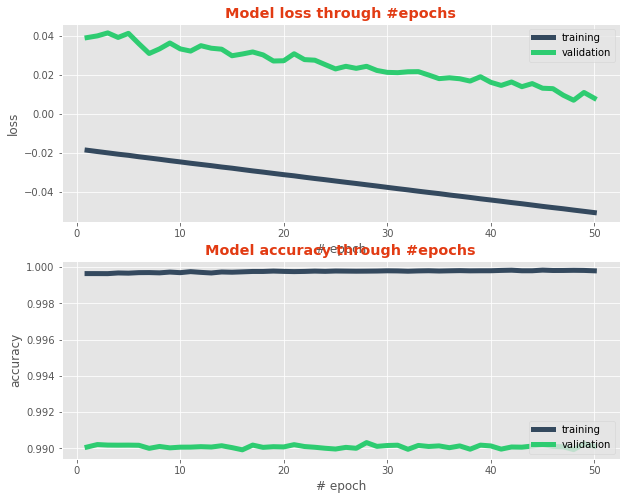

In [89]:
plot_model_performance(
    train_loss=history.history.get('loss', []),
    train_acc=history.history.get('crf_viterbi_accuracy', []),
    train_val_loss=history.history.get('val_loss', []),
    train_val_acc=history.history.get('val_crf_viterbi_accuracy', [])
)

# Función que Permite convertir Indices en Tags

In [90]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

# Hacemos la prediccion sobre el conjunto de pruebas. De la distribución probabilítica a etiquetas. 

In [91]:
import pandas as pd

prediction = model.predict(test_sentences_X)
log_tokens = logits_to_tokens(prediction, {i: t for t, i in tag2index.items()})

print(log_tokens[100])

['O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-

# Predecir sobre un nuevo dato

In [92]:
test_samples = [
    "James Rodriguez fue contratado por el Everton del Reino Unido.".split(),
    "Éste gran hombre ganó con el Real Madrid de España y en Alemania con Roler.".split()
]
#print(max(test_samples))
print(test_samples)

[['James', 'Rodriguez', 'fue', 'contratado', 'por', 'el', 'Everton', 'del', 'Reino', 'Unido.'], ['Éste', 'gran', 'hombre', 'ganó', 'con', 'el', 'Real', 'Madrid', 'de', 'España', 'y', 'en', 'Alemania', 'con', 'Roler.']]


# Convertimos el texto en Una entrada para el Modelo y se generan los dos vecores de enteros de las dos oraciones.

In [93]:
test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)

test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)
print(test_samples_X.shape)

[[ 4041 27296  3619  9963  8052 21761     1 26960  6250     1     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0 

# Se Ejecuta la predicion con la Entrada del modelo entrenado y el modelo de la red neuronal predice un matriz de 1238 X 11 por cada oración. El shape de a predicción es (2, 1238,11)¶ 

In [94]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

[[[0. 0. 0. ... 0. 0. 1.]
  [0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 0. 1. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 1. 0.]
  [0. 0. 0. ... 1. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]] (2, 202, 11)


In [95]:
#print(len(predictions))
log_tokens = logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})
print(log_tokens)

[['B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',

In [96]:
#!pip install tabulate
from tabulate import tabulate

heads1 = test_samples[0]
body1 = [log_tokens[0][:len(test_samples[0])]]

heads2 = test_samples[1]
body2 = [log_tokens[1][:len(test_samples[1])]]

print(tabulate(body1, headers=heads1))

print ("\n")

print(tabulate(body2, headers=heads2))


## postagging Freeling 4.1

## El      hombre   bajo     corre    bajo  el      puente   con  bajo  índice   de  adrenalina  .
## DA0MS0  NCMS000  AQ0MS00  VMIP3S0  SP    DA0MS0  NCMS000  SP   SP    NCMS000  SP  NCFS000     Fp


## pos tagger Stanford NLP

## El      hombre   bajo     corre    bajo  el      puente   con    bajo   índice  de    adrenalina  .
## da0000  nc0s000  aq0000   vmip000  sp000 da0000  nc0s000  sp000  aq0000 nc0s000 sp000 nc0s000     fp

James    Rodriguez    fue    contratado    por    el    Everton    del    Reino    Unido.
-------  -----------  -----  ------------  -----  ----  ---------  -----  -------  --------
B-PER    O            O      O             O      O     O          O      O        O


Éste    gran    hombre    ganó    con    el    Real    Madrid    de     España    y    en    Alemania    con    Roler.
------  ------  --------  ------  -----  ----  ------  --------  -----  --------  ---  ----  ----------  -----  --------
O       B-LOC   I-LOC     O       O      O     B-ORG   I-ORG     I-ORG  I-ORG     O    O     B-LOC       O      O
